# LSTM Model

## 1. Import libraries 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## 2. Đọc Dataset và chia data thành 2 bộ train và test

In [2]:
# Đọc dữ liệu từ file CSV, lấy các cột cần thiết và phân tích cột 'Date' làm chỉ mục
df = pd.read_csv('../Data/gld_price_data.csv', index_col='Date', parse_dates=True, usecols=['Date','GLD', 'USO', 'SLV','EUR/USD'])
# df.sort_values(by='Date', ascending=True, inplace=True)
# df.reset_index(inplace=True)

# Loại bỏ các dòng có giá trị thiếu (NaN) trong dữ liệu
df = df.dropna()

# Tách dữ liệu thành train_data và test_data theo tỉ lệ 80:20
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

# In kích thước của tập dữ liệu huấn luyện
print('Shape of data train', train_data.shape)

# In kích thước của tập dữ liệu kiểm tra
print('Shape of data test', test_data.shape)

# Tách biến mục tiêu 'GLD' từ tập dữ liệu huấn luyện
y_train = train_data['GLD']
y_test = test_data['GLD']

# Tách các biến đầu vào (features) từ tập dữ liệu huấn luyện, loại bỏ cột 'GLD'
X_train = train_data.drop(columns=['GLD'])
X_test = test_data.drop(columns=['GLD'])

Shape of data train (1832, 4)
Shape of data test (458, 4)


## 3. Dataset overview

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2290 entries, 2008-01-02 to 2018-05-16
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GLD      2290 non-null   float64
 1   USO      2290 non-null   float64
 2   SLV      2290 non-null   float64
 3   EUR/USD  2290 non-null   float64
dtypes: float64(4)
memory usage: 89.5 KB


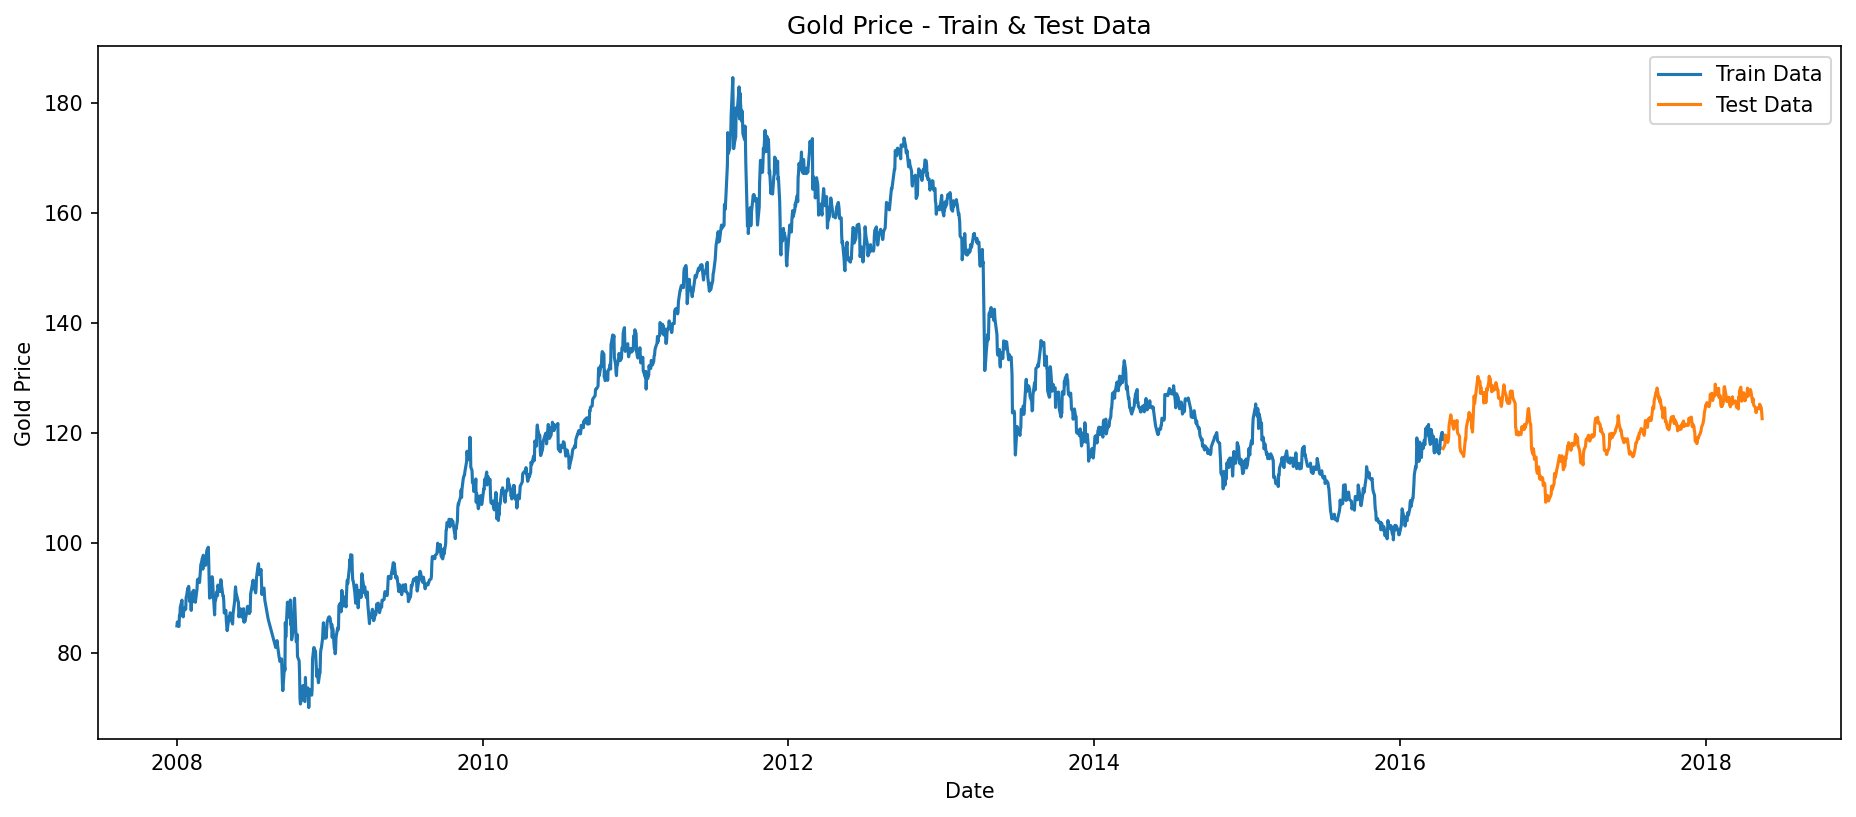

In [4]:
# Thiết lập kích thước biểu đồ với chiều rộng full (ví dụ 15 inch)
plt.figure(figsize=(15, 6), dpi=150)

# Vẽ biểu đồ cho tập huấn luyện (train)
plt.plot(train_data['GLD'], label='Train Data')

# Vẽ biểu đồ cho tập kiểm tra (test)
plt.plot(test_data['GLD'], label='Test Data')

# Thêm tiêu đề và nhãn
plt.title('Gold Price - Train & Test Data')
plt.xlabel('Date')
plt.ylabel('Gold Price')

# Chú thích
plt.legend()

# Hiển thị biểu đồ
plt.grid(color='white')
plt.show()

## 4. Thông tin chi tiết của tập Train và Test

In [5]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1832 entries, 2008-01-02 to 2016-04-13
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GLD      1832 non-null   float64
 1   USO      1832 non-null   float64
 2   SLV      1832 non-null   float64
 3   EUR/USD  1832 non-null   float64
dtypes: float64(4)
memory usage: 71.6 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 458 entries, 2016-04-14 to 2018-05-16
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GLD      458 non-null    float64
 1   USO      458 non-null    float64
 2   SLV      458 non-null    float64
 3   EUR/USD  458 non-null    float64
dtypes: float64(4)
memory usage: 17.9 KB


## 5. Khởi tạo và huấn luyện mô hình LSTM

In [6]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

In [7]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['GLD']])

In [8]:
# Tạo hàm chia dữ liệu thành chuỗi
def create_sequences(data, target_index, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length, target_index])
    return np.array(sequences), np.array(labels)

In [9]:
# Thiết lập tham số
sequence_length = 10
target_index = df.columns.get_loc('GLD') - 1  # Vị trí cột 'GLD' trong scaled_data
train_scaled = scaled_data[:len(train_data)]
test_scaled = scaled_data[len(train_data):]

In [10]:
# Tạo tập train và test
X_train, y_train = create_sequences(train_scaled, target_index, sequence_length)
X_test, y_test = create_sequences(test_scaled, target_index, sequence_length)


In [11]:
# Xây dựng mô hình LSTM

# Khởi tạo mô hình Sequential
model = Sequential()

# Thêm lớp Input để xác định hình dạng đầu vào
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

# Thêm các lớp LSTM và Dense
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

# Compile mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Hiển thị cấu trúc mô hình
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1028 - val_loss: 6.4610e-04
Epoch 2/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - val_loss: 5.2905e-04
Epoch 3/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.9259e-04 - val_loss: 5.5848e-04
Epoch 4/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.9864e-04 - val_loss: 4.4012e-04
Epoch 5/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010 - val_loss: 4.3746e-04
Epoch 6/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.2727e-04 - val_loss: 4.4122e-04
Epoch 7/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.9068e-04 - val_loss: 5.1439e-04
Epoch 8/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.1279e-04 - val_loss: 4.2576e-04
Epoch 9/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.4216e-04 - val_loss: 4.1975e-04
Epoch 10/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.8697e-04 - val_loss: 4.4598e-04
Epoch 11/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.0607e-04 - val_los

### 6. Dự đoán và tính toán các độ đo

In [13]:
# Dự đoán trên tập test
predictions = model.predict(X_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


In [14]:
# Tạo cột giả với các giá trị 0 có kích thước phù hợp với predictions
dummy_features = np.zeros((predictions.shape[0], scaled_data.shape[1] - 1))

# Nối cột dự đoán vào cột giả
predictions_rescaled = scaler.inverse_transform(
    np.hstack([dummy_features, predictions])
)[:, -1]

# Tương tự cho y_test
dummy_features_test = np.zeros((y_test.shape[0], scaled_data.shape[1] - 1))

y_test_rescaled = scaler.inverse_transform(
    np.hstack([dummy_features_test, y_test.reshape(-1, 1)])
)[:, -1]



In [15]:
# Tính toán các chỉ số

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)

# Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test_rescaled, predictions_rescaled) * 100 

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))

# R-squared (R²)
r2 = r2_score(y_test_rescaled, predictions_rescaled)

print(f"MAE: {mae}")
print(f"MAPE: {mape}%")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 0.7483058171582737
MAPE: 0.6156335220976104%
RMSE: 1.0092538359295413
R²: 0.9572173785272453


### 7. Biểu đồ dự đoán của mô hình

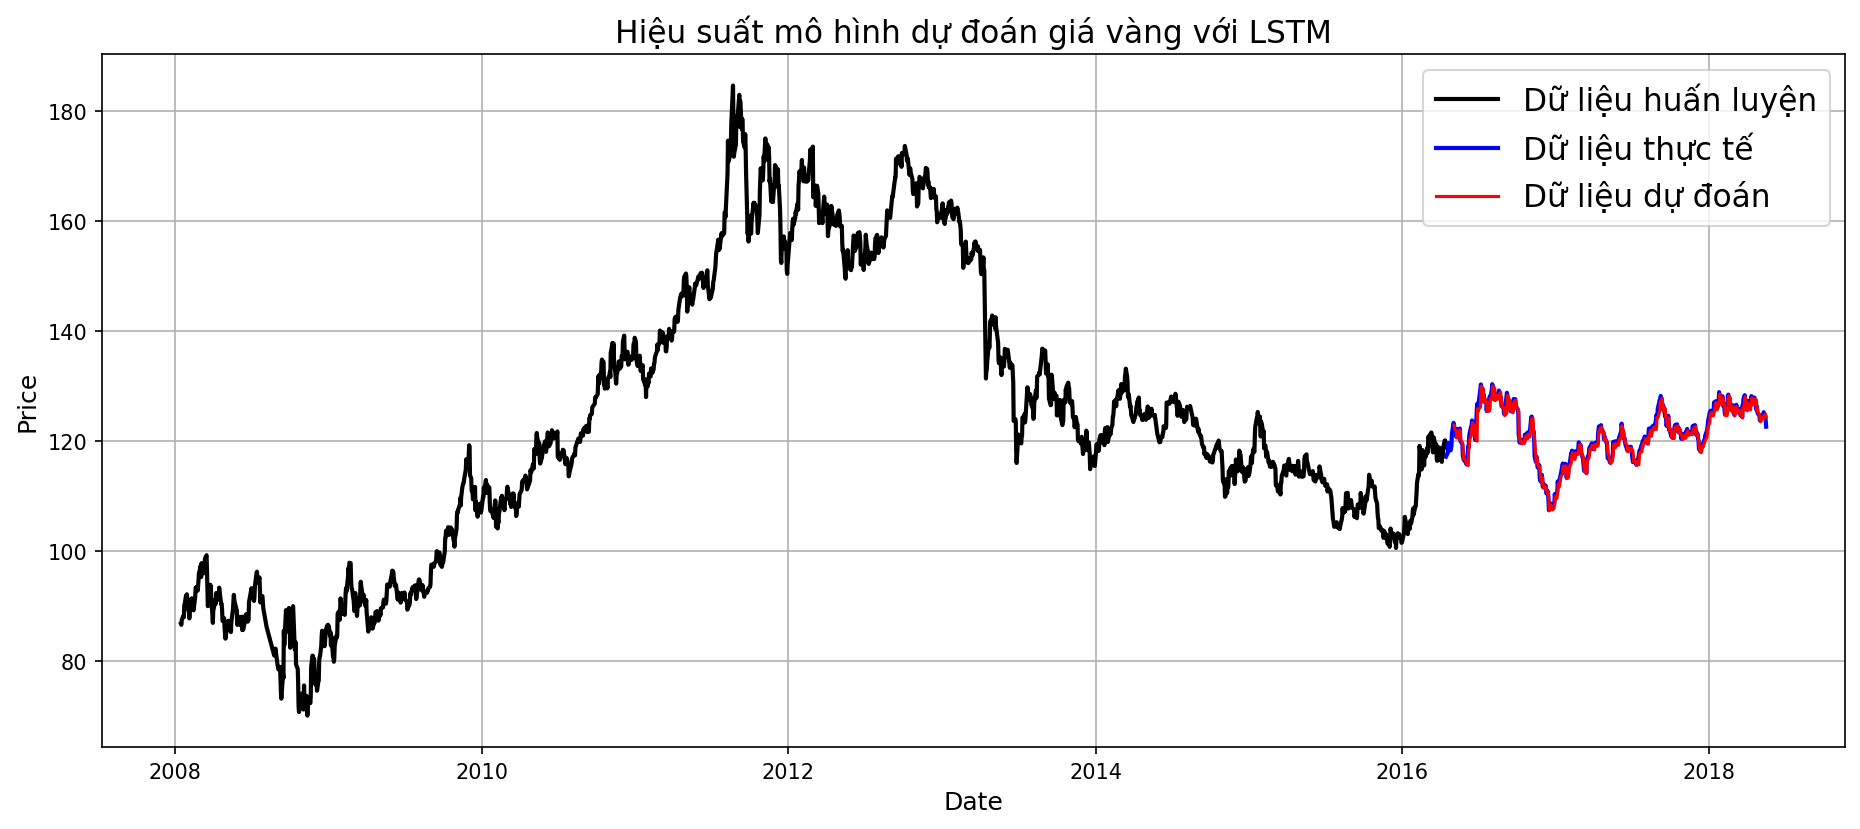

In [16]:
plt.figure(figsize=(15, 6), dpi=150)

# Nếu dữ liệu đã được chuẩn hóa, cần chuyển ngược lại về giá trị gốc
y_train_rescaled = scaler.inverse_transform(y_train.reshape(-1, 1))
# Sau đó vẽ lại dữ liệu huấn luyện
plt.plot(train_data.index[sequence_length:], y_train_rescaled, color='black', lw=2, label='Dữ liệu huấn luyện')

# Vẽ dữ liệu thực tế (test set)
plt.plot(test_data.index, test_data['GLD'], label='Dữ liệu thực tế', lw=2, color='blue')

# Vẽ dữ liệu dự đoán (dùng sequence_length để căn chỉnh)
plt.plot(test_data.index[sequence_length:], predictions_rescaled, label='Dữ liệu dự đoán', color='red')

# Thêm tiêu đề và nhãn
plt.title('Hiệu suất mô hình dự đoán giá vàng với LSTM', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True)

# Hiển thị legend
plt.legend(['Dữ liệu huấn luyện', 'Dữ liệu thực tế', 'Dữ liệu dự đoán'], prop={'size': 15})

# Hiển thị biểu đồ
plt.show()
